In [1]:
using Images
using ProgressMeter
using Statistics
using LinearAlgebra
using Plots

Establish the genres we will be analyzing. We will only be considering the three genres Classical, EDM, Rock.

In [55]:
SPEC_DIR = "spectrograms"

GENRES = ["classical", "edm", "rock"]

3-element Array{String,1}:
 "classical"
 "edm"      
 "rock"     

PCA on frequency averages
=========================

Take the average amplitude per mel-frequency over the entire song and run PCA with frequencies as variables.

The following code creates our initial matrix:

In [3]:
A = zeros(367, 288)

367×288 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

It will then iterate through all the song spectrograms, which are organized into folders by genre.

The inside of the for loop first loads the image from the path, then converts the image to grayscale, then uses channelview to convert it into a matrix.

Once the grayscale channelview is created and stored in im, the next line will iterate through each entry in each row and average them, resulting in a 1 column matrix, which we can then concatenate to our initial matrix.

At the end of this step, we should have a matrix with where each row represents a song and each column represents the average of the row of that song's image.

In [56]:
counter = 1

for genre in GENRES
    println(genre)
    for (root, dir, files) in walkdir(joinpath(SPEC_DIR, genre))
        @showprogress for image in files
            if !occursin(".png", image) continue end
            if occursin("checkpoint", image) continue end
            
            im = channelview(Gray.(load(joinpath(SPEC_DIR, genre, image))))
            ra = [mean(im[i, :]) for i = 1:size(im)[1]]
            A[counter, :] = ra'
            global counter
            counter += 1
        end
    end
end

classical


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

edm


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

rock


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


This will center the data:

In [5]:
A_centered = [A[i, j] - mean(A[:, j]) for i=1:size(A)[1], j=1:size(A)[2]]

367×288 Array{Float64,2}:
 -0.100749    -0.100749    -0.100749    …   0.00590338   0.00590338
 -0.102982    -0.102982    -0.102982       -0.202212    -0.202212  
 -0.0808596   -0.0808596   -0.0808596      -0.100115    -0.100115  
 -0.0650463   -0.0650463   -0.0650463      -0.197982    -0.197982  
 -0.0996232   -0.0996232   -0.0996232      -0.0625607   -0.0625607 
 -0.08745     -0.08745     -0.08745     …  -0.129627    -0.129627  
 -0.102764    -0.102764    -0.102764       -0.18973     -0.18973   
 -0.098779    -0.098779    -0.098779       -0.107386    -0.107386  
 -0.101784    -0.101784    -0.101784       -0.122737    -0.122737  
 -0.102219    -0.102219    -0.102219       -0.361508    -0.361508  
 -0.100513    -0.100513    -0.100513    …  -0.170549    -0.170549  
 -0.0783814   -0.0783814   -0.0783814      -0.203174    -0.203174  
 -0.0777278   -0.0777278   -0.0777278      -0.0531743   -0.0531743 
  ⋮                                     ⋱                          
  0.0592184    0.05921

Followed by the steps for normalizing each column.

First we calculate the magnitude of each column:

In [6]:
ColLength = [sqrt(sum(A_centered[i, j]^2 for i=1:size(A)[1])) for j=1:size(A)[2]]

288-element Array{Float64,1}:
 1.3630272613664094
 1.3630272613664094
 1.3630272613664094
 2.173582161547399 
 2.173582161547399 
 2.444972788274052 
 2.444972788274052 
 2.51097417508183  
 2.51097417508183  
 2.520274852074242 
 2.520274852074242 
 2.520274852074242 
 2.530216704462127 
 ⋮                 
 1.6463783981693414
 1.715825051758548 
 1.715825051758548 
 1.7248177231220216
 1.7248177231220216
 1.7248177231220216
 1.9639337439571094
 1.9639337439571094
 2.548006712969892 
 2.548006712969892 
 2.1372626507176378
 2.1372626507176378

Then we apply the normalization by dividing each entry in each column by the column vector's magnitude:

In [7]:
B = [A_centered[i, j] / ColLength[j] for i=1:size(A)[1], j=1:size(A)[2]]

367×288 Array{Float64,2}:
 -0.0739155   -0.0739155   -0.0739155   …   0.00276212   0.00276212
 -0.0755539   -0.0755539   -0.0755539      -0.0946127   -0.0946127 
 -0.0593236   -0.0593236   -0.0593236      -0.0468427   -0.0468427 
 -0.0477219   -0.0477219   -0.0477219      -0.0926334   -0.0926334 
 -0.0730897   -0.0730897   -0.0730897      -0.0292714   -0.0292714 
 -0.0641587   -0.0641587   -0.0641587   …  -0.0606508   -0.0606508 
 -0.075394    -0.075394    -0.075394       -0.0887725   -0.0887725 
 -0.0724703   -0.0724703   -0.0724703      -0.0502448   -0.0502448 
 -0.0746748   -0.0746748   -0.0746748      -0.0574271   -0.0574271 
 -0.0749944   -0.0749944   -0.0749944      -0.169145    -0.169145  
 -0.0737424   -0.0737424   -0.0737424   …  -0.0797979   -0.0797979 
 -0.0575054   -0.0575054   -0.0575054      -0.0950629   -0.0950629 
 -0.0570259   -0.0570259   -0.0570259      -0.0248796   -0.0248796 
  ⋮                                     ⋱                          
  0.0434463    0.04344

Taking the SVD of this centered and normalized matrix:

In [8]:
U, sigma, V = svd(B, full=true)

SVD{Float64,Float64,Array{Float64,2}}([-0.0515259 0.0109508 … -0.0456978 0.0104162; -0.101259 0.13274 … -0.0333527 0.013537; … ; -0.0109382 0.0161358 … 0.279909 0.0217928; 0.0286121 0.00324483 … -0.0525047 0.103294], [15.0821, 4.3681, 2.99299, 2.28204, 1.96574, 1.91647, 1.5468, 1.47368, 1.40987, 1.17405  …  1.3214e-15, 1.3214e-15, 1.3214e-15, 1.3214e-15, 1.3214e-15, 1.3214e-15, 1.3214e-15, 1.3214e-15, 1.3214e-15, 1.3214e-15], [0.0579752 0.0579752 … 0.0404884 0.0404884; -0.0607895 -0.0607895 … -0.0353443 -0.0353443; … ; 0.0 -3.30482e-18 … 2.4255e-18 -3.89391e-18; 0.0 6.39441e-18 … -5.03482e-18 -9.78929e-18])

Now we can project our matrix onto each of the principal components we want to consider. The results will be stored in y1, y2, and y3, with number corresponding to the number of the principal component our data was projected on.

In [9]:
y1 = B * V[:, 1]
y2 = B * V[:, 2]
y3 = B * V[:, 3]

367-element Array{Float64,1}:
 -0.15068702206654627 
  0.014627199786815766
  0.03659376572612843 
 -0.27911168820617    
 -0.18721025228439608 
 -0.08809988824695517 
 -0.41161330047896066 
  0.26548510311997947 
 -0.24097332845440445 
 -0.06133543534079852 
 -0.0818861467008116  
 -0.04407049789763785 
  0.00893812744037022 
  ⋮                   
 -0.14857511341875276 
  0.05608749394133934 
  0.1832036623936386  
  0.13846651889311662 
  0.1732038626192169  
 -0.0353804221746455  
 -0.11013473729328727 
 -0.016938320272756522
  0.10954133475111644 
 -0.14462554978818515 
  0.30876125066406745 
  0.21516214493393274 

For analysis, the following two lines plot our first two principal components:

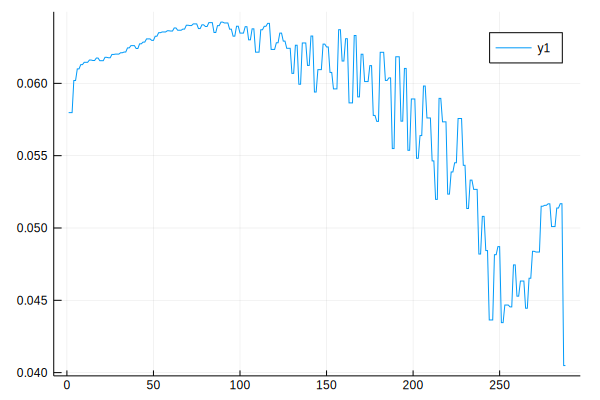

In [10]:
plot(V[:, 1])

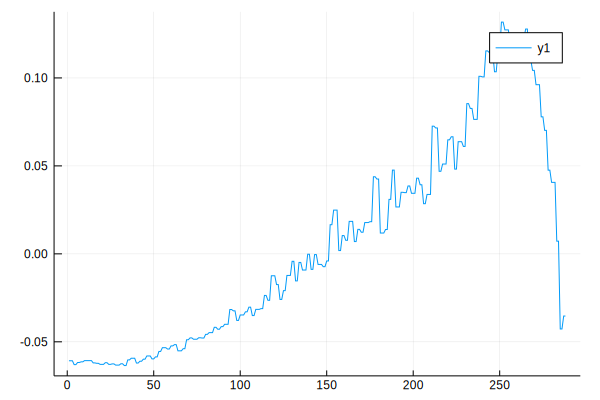

In [11]:
plot(V[:, 2])

Finally, we can produce a scatterplot of the projection of our data onto the first two principal components. The following code plots each of the genres in a different color.

In [54]:
asdfsaasdf

UndefVarError: UndefVarError: asdfsaasdf not defined

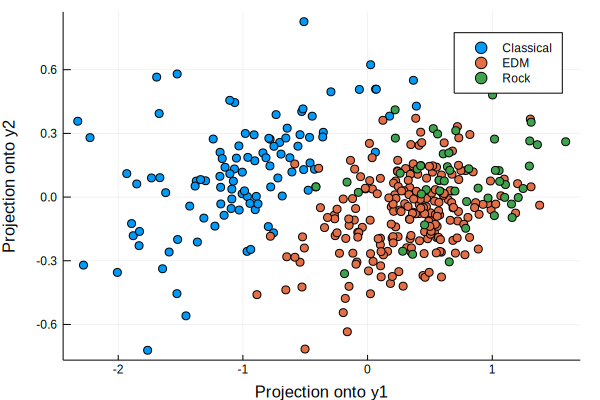

In [12]:
scatter(y1[1:103], y2[1:103], label="Classical")
scatter!(y1[104:104+216-1], y2[104:104+216-1], label="EDM")
scatter!(y1[104+216:size(y1)[1]], y2[104+216:size(y2)[1]], label="Rock")

xlabel!("Projection onto v1")
ylabel!("Projection onto v2")

We will also take the mean and standard deviations of the projections for each genre:

In [13]:
mean(y1[1:103])

-1.0017484776941887

In [14]:
mean(y1[104:104+216-1])

0.31828584021363104

In [15]:
mean(y1[104+216:size(y1)[1]])

0.717298994090774

In [16]:
mean(y2[1:103])

0.11980376181489054

In [17]:
mean(y2[104:104+216-1])

-0.07567816209553406

In [18]:
mean(y2[104+216:size(y1)[1]])

0.08347282386878419

In [19]:
std(y2[1:103])

0.26128190478054103

In [20]:
std(y2[104:104+216-1])

0.18726373603641375

In [21]:
std(y2[104+216:size(y1)[1]])

0.18027736232735367

We can also find the tracks with the last and most bass by finding the ones with the highest and lowest projections on the first principal component.

In [22]:
argmin(y1)

37

In [23]:
y1[37]

-2.324579381674341

In [62]:
argmax(y1)

338

In [25]:
y1[338]

1.5889577055966682

In [26]:
338-103-216

19

Things to analyze
-----------------
 - STDEV of v2 - treble
 - average projection onto v1 - bass amount

PCA on resized spectrogram
==========================

In this second method, we will try to take in more data from each song's spectrogram. Rather than averaging the entirety of the spectrogram by row, thus decompressing our data into just one, length 288 vector, we will take the average of even portions of the spectrogram by row. In this case, we set our spectrogram to divide into 20 equal pieces, which should turn each spectrogram into a vector of length 5760, hopefully capturing more of the song's information and characteristics.

In [28]:
WIDTH = 20

20

This creates our larger initial matrix for this method:

In [29]:
A = zeros(367, 288 * WIDTH)

367×5760 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

Now we want to iterate through our spectrograms again and add their data into the the matrix.

The inside of the for loop first loads the image from the path, then converts the image to grayscale, then uses channelview to convert it into a matrix.

The reshape command resizes the image to have our given width. In this process, Julia automatically takes the average of the pixels being removed due to the resize for each section. Thus, giving us an average for each of the parts we divide the spectrogram into.

At the end of this step, we should have a matrix with where each row represents a song and each column represents the average of the row of that song's spectrogram for one of the fractions of the spectrogram.

In [30]:
counter = 1

for genre in GENRES
    println(genre)
    for (root, dir, files) in walkdir(joinpath(SPEC_DIR, genre))
        @showprogress for image in files
            if !occursin(".png", image) continue end
            if occursin("checkpoint", image) continue end
            
            ra = reshape(channelview(Gray.(imresize(load(joinpath(SPEC_DIR, genre, image)), (288, WIDTH)))), 1, 288 * WIDTH)
            A[counter, :] = ra'
            global counter
            counter += 1
        end
    end
end

classical


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

edm


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

rock


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


The following will center and normalize the data, just like we did for our first method:

In [31]:
A_centered = [A[i, j] - mean(A[:, j]) for i=1:size(A)[1], j=1:size(A)[2]]

367×5760 Array{Float64,2}:
 -0.0267244   -0.0267244   …  -0.225538    -0.119111   -0.119111 
 -0.0267244   -0.0267244      -0.276519    -0.283817   -0.283817 
 -0.0267244   -0.0267244       0.0764225    0.0730459   0.0730459
 -0.0267244   -0.0267244      -0.0569108    0.0534381   0.0534381
 -0.0267244   -0.0267244       0.00975584   0.10834     0.10834  
 -0.0267244   -0.0267244   …   0.433285     0.331869    0.331869 
 -0.0267244   -0.0267244      -0.131421    -0.0759737  -0.0759737
 -0.0267244   -0.0267244      -0.398087    -0.299503   -0.299503 
 -0.0267244   -0.0267244       0.421521     0.371085    0.371085 
 -0.0267244   -0.0267244      -0.139264    -0.150484   -0.150484 
 -0.0267244   -0.0267244   …  -0.398087    -0.334797   -0.334797 
 -0.0267244   -0.0267244       0.190148     0.194615    0.194615 
 -0.0267244   -0.0267244       0.29603      0.288732    0.288732 
  ⋮                        ⋱                                     
  0.0634717    0.0634717   …  -0.139264    -0.197

In [32]:
ColLength = [sqrt(sum(A_centered[i, j]^2 for i=1:size(A)[1])) for j=1:size(A)[2]]

5760-element Array{Float64,1}:
 1.0627190543437819
 1.0627190543437819
 1.0627190543437819
 1.9727442269568354
 1.9727442269568354
 2.4579016365403703
 2.4579016365403703
 2.578092147407204 
 2.578092147407204 
 2.5988779040664887
 2.5988779040664887
 2.5988779040664887
 2.621863218663278 
 ⋮                 
 5.310773204382356 
 5.3614956243519805
 5.3614956243519805
 5.503191048910772 
 5.503191048910772 
 5.503191048910772 
 5.802942234592292 
 5.802942234592292 
 6.005779217006543 
 6.005779217006543 
 5.484349629822994 
 5.484349629822994 

In [33]:
B = [A_centered[i, j] / ColLength[j] for i=1:size(A)[1], j=1:size(A)[2]]

367×5760 Array{Float64,2}:
 -0.0251472   -0.0251472   -0.0251472   …  -0.0217183   -0.0217183 
 -0.0251472   -0.0251472   -0.0251472      -0.0517503   -0.0517503 
 -0.0251472   -0.0251472   -0.0251472       0.013319     0.013319  
 -0.0251472   -0.0251472   -0.0251472       0.00974374   0.00974374
 -0.0251472   -0.0251472   -0.0251472       0.0197544    0.0197544 
 -0.0251472   -0.0251472   -0.0251472   …   0.0605121    0.0605121 
 -0.0251472   -0.0251472   -0.0251472      -0.0138528   -0.0138528 
 -0.0251472   -0.0251472   -0.0251472      -0.0546105   -0.0546105 
 -0.0251472   -0.0251472   -0.0251472       0.0676626    0.0676626 
 -0.0251472   -0.0251472   -0.0251472      -0.0274387   -0.0274387 
 -0.0251472   -0.0251472   -0.0251472   …  -0.0610459   -0.0610459 
 -0.0251472   -0.0251472   -0.0251472       0.0354854    0.0354854 
 -0.0251472   -0.0251472   -0.0251472       0.0526466    0.0526466 
  ⋮                                     ⋱                          
  0.0597258    0.0597

Now we can take the SVD to find our principal component vectors:

In [34]:
U, sigma, V = svd(B, full=true)

SVD{Float64,Float64,Array{Float64,2}}([-0.0585254 0.0208515 … 0.0114521 -0.0521996; -0.107973 0.0279488 … 0.000921537 -0.0521996; … ; -0.0145938 -0.0695947 … -0.0304829 -0.0521996; 0.0175599 -0.0430312 … 0.00469571 -0.0521996], [44.7475, 16.7982, 14.1846, 12.9951, 12.6665, 11.7189, 11.2176, 10.7663, 10.3154, 9.69363  …  0.799731, 0.793832, 0.786392, 0.779941, 0.76949, 0.757895, 0.7497, 0.73873, 0.680919, 3.80418e-14], [0.00783639 0.00783639 … 0.00176378 0.00176378; -0.0107123 -0.0107123 … -0.0300679 -0.0300679; … ; -0.0082607 -0.0020449 … 0.872078 -0.127922; -0.0082607 -0.0020449 … -0.127922 0.872078])

We then project our data matrix onto the principal component vectors. We will only use the first three.

In [35]:
y1 = B * V[:, 1]
y2 = B * V[:, 2]
y3 = B * V[:, 3]

367-element Array{Float64,1}:
 -0.2847056375796723  
 -0.15575941687899258 
  2.658267749315849   
 -0.08422971763878734 
 -0.3133055805662575  
  0.4368861718305109  
 -0.4848690831339454  
  1.5298782428028594  
  0.6266427605339993  
 -0.3434767409236757  
  1.3795698673572534  
 -0.12671607785889144 
  0.982481688759673   
  ⋮                   
 -0.5032815620952061  
 -0.1563653192336304  
  0.44679952728784517 
  0.026188136634189202
  0.9585337364155482  
 -0.23514806345741    
  0.45946707985651575 
  0.3975854374019341  
 -0.18405531183602225 
  1.4073509697521442  
  0.506493350011533   
  0.1622076029236086  

We can also plot the graphs of the principal component vectors to better analyze what they are representing and what is causing the most variance in our data

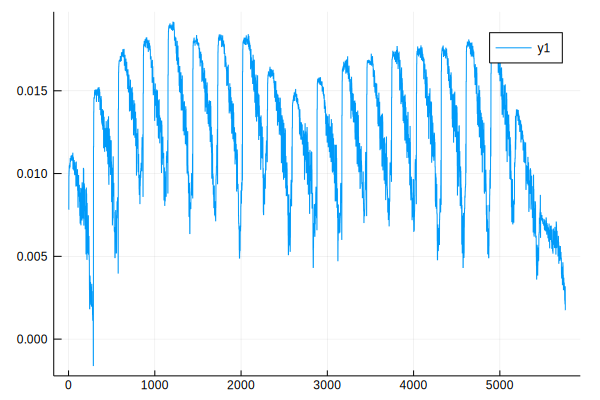

In [36]:
plot(V[:, 1])

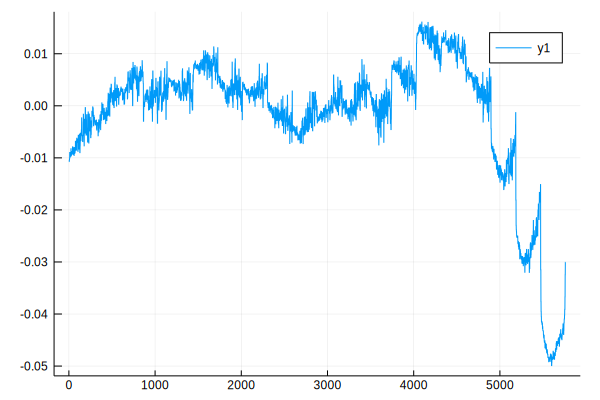

In [37]:
plot(V[:, 2])

Finally, we can plot the projections of our data onto the first and second principal component vectors to make a 2D graph, and then to the first three principal component vectors to make a 3D graph.

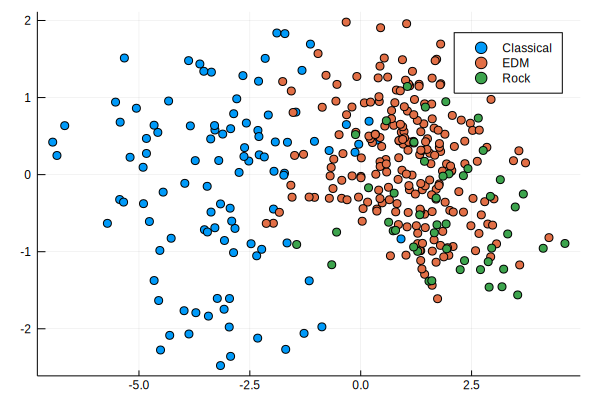

In [57]:
scatter(y1[1:103], y2[1:103], label = "Classical")
scatter!(y1[104:104+216-1], y2[104:104+216-1], label = "EDM")
scatter!(y1[104+216:size(y1)[1]], y2[104+216:size(y2)[1]], label = "Rock")

Things to analyze
-----------------
 - STDEV of v2 - song ending time
 - non-genre feature, but classical tends to have a more varied ending time, while EDM tends to fade out earlier
 - average projection onto v1 - bass amount

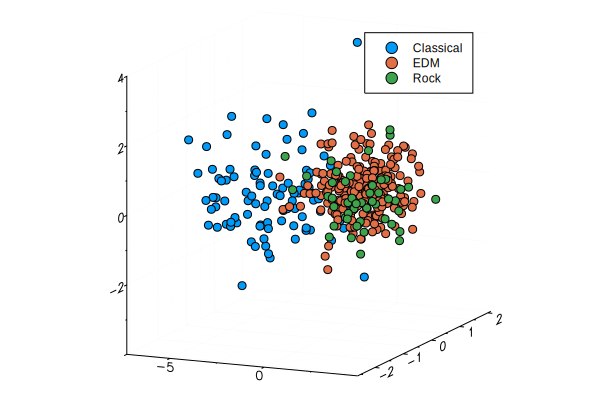

In [58]:
scatter(y1[1:103], y2[1:103], y3[1:103], label = "Classical")
scatter!(y1[104:104+216-1], y2[104:104+216-1], y3[104:104+216-1], label = "EDM")
scatter!(y1[104+216:size(y1)[1]], y2[104+216:size(y2)[1]], y3[104+216:size(y2)[1]], label = "Rock")

Given that the second principal component corresponds almost solely to the variance in each song's last few portions, we might want to consider only projecting the data onto the first and third principal components, which gives us the following:

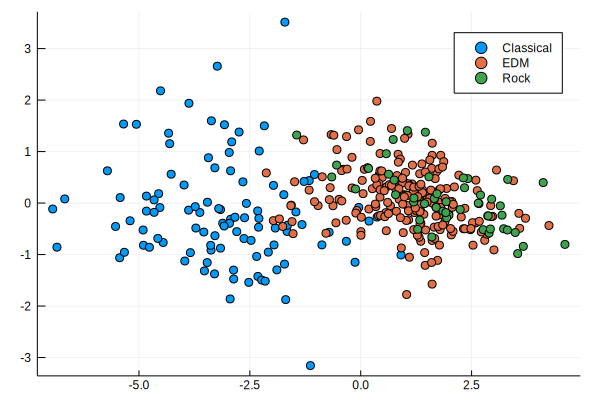

In [61]:
scatter(y1[1:103], y3[1:103], label = "Classical")
scatter!(y1[104:104+216-1], y3[104:104+216-1], label = "EDM")
scatter!(y1[104+216:size(y2)[1]], y3[104+216:size(y2)[1]], label = "Rock")

We can also take the mean and standard deviations of each song's projection onto the first and second principal component when we use this method.

In [41]:
mean(y1[1:103])

-3.0902860864646047

In [42]:
mean(y1[104:104+216-1])

1.045969967978945

In [43]:
mean(y1[104+216:size(y1)[1]])

1.9243740379667174

In [60]:
std(y1[1:103])

1.5553278803325503

In [45]:
std(y1[104:104+216-1])

1.1421370676396128

In [46]:
std(y1[104+216:size(y1)[1]])

1.283489531417356

In [47]:
mean(y2[1:103])

-0.13193520164627706

In [48]:
mean(y2[104:104+216-1])

0.16333646823618178

In [49]:
mean(y2[104+216:size(y1)[1]])

-0.4519031535301812

In [50]:
std(y2[1:103])

1.0925490231718333

In [51]:
std(y2[104:104+216-1])

0.7370379662747741

In [52]:
std(y2[104+216:size(y1)[1]])

0.7476712013811345